## 1. Reading the dataset

In [45]:
#https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
import pandas as pd
import warnings
# Ignore all warnings globally
warnings.filterwarnings("ignore")


data = pd.read_csv('DATASET.csv')

In [46]:
#Checking the top 5 values
data.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


## 2. Checking the Null Values

In [47]:
data.isnull().sum()

event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64

In [48]:
data[data['final_order_status'].isnull()]['event_type'].unique()

array(['reload_the_page', 'entry_to_shop'], dtype=object)

### The final order status is null for reload_the_page and entry_to_shop indicating that there was no further interaction.

## 3. Creating a new conversion status column

In [49]:
# Creating a new conversion status column, which indicates if order was cancelled or if it had null value then there was no order placed
#If it was successful or refunded after delivery it means that order was successfully placed
def adjust_conversion_status(row):
    if row['final_order_status'] == 'successful':
        return 'success'
    elif row['final_order_status'] == 'refunded_after_delivery':
        return 'success'  # Refund after delivery is still a successful order
    elif row['final_order_status'] == 'cancelled':
        return 'failure'
    elif pd.isna(row['final_order_status']):
        return 'failure'  # Or you can treat this as '0' or 'cancelled'
    else:
        return 'failure'  # For any other unexpected statuses

# Apply conversion logic to dataset
data['conversion_status'] = data.apply(adjust_conversion_status, axis=1)


In [50]:
# Separate the dataset into control and test groups based on the variation column
control_group = data[data['variation'] == 1]
test_group = data[data['variation'] == 2]

In [51]:
unique_users_per_variation = data.groupby('variation')['user_id'].nunique()

In [52]:
#Unique users for control and test group
unique_users_per_variation

variation
1    65000
2    35000
Name: user_id, dtype: int64

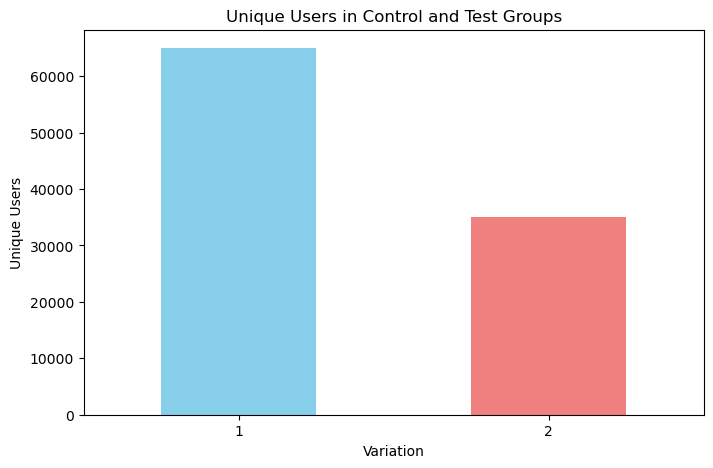

In [53]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(8, 5))
unique_users_per_variation.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Unique Users in Control and Test Groups')
plt.xlabel('Variation')
plt.ylabel('Unique Users')
plt.xticks(rotation=0)  # Make sure the x-axis labels are horizontal
plt.show()

In [54]:
# Check if test/control groups are balanced by platform at user level
control_user_platform_dist = control_group['platform'].value_counts(normalize=True)
test_user_platform_dist = test_group['platform'].value_counts(normalize=True)

print("Control Group Platform Distribution:", control_user_platform_dist)
print("Test Group Platform Distribution:", test_user_platform_dist)

Control Group Platform Distribution: Android    0.690384
iOS        0.309616
Name: platform, dtype: float64
Test Group Platform Distribution: Android    0.692378
iOS        0.307622
Name: platform, dtype: float64


## 4. Grouping the users, if they have any success then success else failure

In [55]:
# Group by 'user_id' and determine if a user is successful (any "success" in their sessions)
def aggregate_user_status(group):
    if 'success' in group['conversion_status'].values:
        return 'success'  # User is successful if any session is a success
    else:
        return 'failure'  # User is a failure if no session is a success

# Apply the aggregation by user
user_conversion_status = data.groupby('user_id').apply(aggregate_user_status).reset_index(name='final_conversion_status')

# Merge back the final conversion status with the original data (optional)
data = data.merge(user_conversion_status, on='user_id', how='left')


In [56]:
# Event-level data for detailed behavioral analysis (non-deduplicated)
event_level_data = data  # All rows retained here

#Keeping the last entry for the users 
data = data.drop_duplicates(subset=['user_id'], keep='last')

## 5.Checking the conversion rate for both the groups

In [57]:
#Creating the control and test group
control_group = data[data['variation'] == 1]
test_group = data[data['variation'] == 2]

# Count the number of successes in each group
control_conversions = control_group[control_group['final_conversion_status'] == 'success'].shape[0]
test_conversions = test_group[test_group['final_conversion_status'] == 'success'].shape[0]

# Count the total number of users in each group
control_group_size = control_group.shape[0]
test_group_size = test_group.shape[0]

# Calculate conversion rates
control_conversion_rate = control_conversions / control_group_size
test_conversion_rate = test_conversions / test_group_size

print(f"Control Group Conversion Rate: {control_conversion_rate}")
print(f"Test Group Conversion Rate: {test_conversion_rate}")


Control Group Conversion Rate: 0.38953846153846156
Test Group Conversion Rate: 0.3851428571428571


## 6. Calculating the statistical significance for both the groups using Z-Statistics

In [58]:
import math
from scipy.stats import norm

# Calculate the pooled conversion rate (overall success rate)
pooled_conversion_rate = (control_conversions + test_conversions) / (control_group_size + test_group_size)

# Standard error (SE) for the Z-test
se = math.sqrt(pooled_conversion_rate * (1 - pooled_conversion_rate) * (1 / control_group_size + 1 / test_group_size))

# Z-statistic
z_statistic = (test_conversion_rate - control_conversion_rate) / se

# P-value for the Z-test (one-tailed)
p_value = norm.cdf(z_statistic)  # For a one-tailed test

print(f"Z-statistic: {z_statistic}")
print(f"P-value: {p_value}")


Z-statistic: -1.36056008436951
P-value: 0.08682637646247987


## 7. Conversion rate by Platform

In [59]:
# Conversion rate by platform in control and test groups
control_platform_conversion = control_group.groupby('platform')['conversion_status'].value_counts(normalize=True).unstack()
test_platform_conversion = test_group.groupby('platform')['conversion_status'].value_counts(normalize=True).unstack()

print("Control Group Platform Conversion Rates:")
print(control_platform_conversion)

print("Test Group Platform Conversion Rates:")
print(test_platform_conversion)


Control Group Platform Conversion Rates:
conversion_status   failure   success
platform                             
Android            0.743367  0.256633
iOS                0.714980  0.285020
Test Group Platform Conversion Rates:
conversion_status   failure   success
platform                             
Android            0.749562  0.250438
iOS                0.712018  0.287982


## 8. Conversion rate by event type

In [60]:
# Analyze conversion rate per event type
control_event_conversion = control_group.groupby('event_type')['conversion_status'].value_counts(normalize=True).unstack()
test_event_conversion = test_group.groupby('event_type')['conversion_status'].value_counts(normalize=True).unstack()

# Compare conversion rates between control and test groups
print(control_event_conversion)
print(test_event_conversion)


conversion_status   failure   success
event_type                           
entry_to_shop      1.000000       NaN
order_finished     0.097213  0.902787
reload_the_page    1.000000       NaN
conversion_status   failure   success
event_type                           
entry_to_shop      1.000000       NaN
order_finished     0.105315  0.894685
reload_the_page    1.000000       NaN


## 9. Conversion rate by temporal

In [61]:
# Create time-based features
data['datetime_event'] = pd.to_datetime(data['datetime_event'])
data['hour'] = data['datetime_event'].dt.hour
data['weekday'] = data['datetime_event'].dt.weekday

control_group = data[data['variation'] == 1]
test_group = data[data['variation'] == 2]


# Check conversion rates by hour of the day
control_hourly_conversion = control_group.groupby('hour')['conversion_status'].value_counts(normalize=True).unstack()
test_hourly_conversion = test_group.groupby('hour')['conversion_status'].value_counts(normalize=True).unstack()

# Check conversion rates by day of the week
control_weekday_conversion = control_group.groupby('weekday')['conversion_status'].value_counts(normalize=True).unstack()
test_weekday_conversion = test_group.groupby('weekday')['conversion_status'].value_counts(normalize=True).unstack()


## 10. Temporal Analysis - Weekday

In [62]:
control_weekday_conversion

conversion_status,failure,success
weekday,,
0,0.738814,0.261186
1,0.735784,0.264216
2,0.742393,0.257607
3,0.732653,0.267347
4,0.735472,0.264528
5,0.732259,0.267741
6,0.075949,0.924051


In [63]:
test_weekday_conversion

conversion_status,failure,success
weekday,,
0,0.744670,0.255330
1,0.732193,0.267807
2,0.738023,0.261977
3,0.738757,0.261243
4,0.741280,0.258720
5,0.737676,0.262324
6,0.190476,0.809524


## 11. Temporal Analysis - Hourly

In [64]:
control_hourly_conversion

conversion_status,failure,success
hour,,
0,0.086860,0.913140
1,NaN,1.000000
7,1.000000,NaN
8,0.900000,0.100000
9,0.750000,0.250000
10,0.797297,0.202703
11,0.854545,0.145455
12,0.840722,0.159278
13,0.801444,0.198556


In [65]:
test_hourly_conversion

conversion_status,failure,success
hour,,
0,0.153488,0.846512
1,0.166667,0.833333
2,NaN,1.000000
7,NaN,1.000000
8,1.000000,NaN
9,0.750000,0.250000
10,0.795455,0.204545
11,0.798246,0.201754
12,0.815562,0.184438


## Acknowledgments

Some portions of the code in this notebook were generated using OpenAI's ChatGPT, an AI language model. While ChatGPT assists in code generation, the author has reviewed and validated all AI-generated code to ensure its accuracy and relevance to this project.